In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df_complaints = pd.read_excel('/content/drive/MyDrive/Hackaton/Code/complaints.xlsx')
print(df_complaints.head(5))

   customerID                                          complaint  \
0  9565-DJPIB  The streaming TV service frequently buffers or...   
1  4342-HFXWS  The DSL internet service has been inconsistent...   
2  4342-HFXWS  The streaming TV service often buffers excessi...   
3  4342-HFXWS  Despite having tech support included, it takes...   
4  4342-HFXWS  The device protection plan I pay for did not c...   

   complaint_number  
0                 1  
1                 1  
2                 2  
3                 3  
4                 4  


# Text Preprocessing

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [5]:
df_complaints['clean_complaint'] = df_complaints['complaint'].astype(str).apply(clean_text)
df_complaints.head()

,customerID,complaint,complaint_number,clean_complaint
0,9565-DJPIB,The streaming TV service frequently buffers or...,1,streaming tv service frequently buffer crash m...
1,4342-HFXWS,The DSL internet service has been inconsistent...,1,dsl internet service inconsistent lately frequ...
2,4342-HFXWS,The streaming TV service often buffers excessi...,2,streaming tv service often buffer excessively ...
3,4342-HFXWS,"Despite having tech support included, it takes...",3,despite tech support included take long time g...
4,4342-HFXWS,The device protection plan I pay for did not c...,4,device protection plan pay cover recent issue ...


# PCA

TF-IDF shape: (1605, 1260)
Optimal number of components for 90% variance: 95


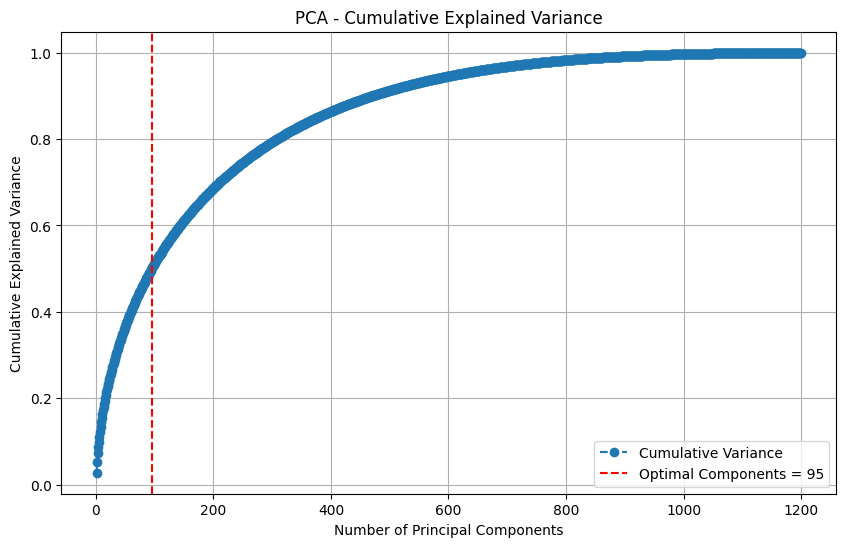

In [8]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df_complaints['clean_complaint'])
print("TF-IDF shape:", X_tfidf.shape)

X_dense = X_tfidf.toarray()

n_components = min(1200, X_dense.shape[1])

pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_dense)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

threshold = 0.5
indices = np.where(cumulative_variance >= threshold)[0]
if len(indices) > 0:
    optimal_components = indices[0] + 1
else:
    optimal_components = n_components
    print("Threshold not reached. Using maximum components:", n_components)

print("Optimal number of components for 90% variance:", optimal_components)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--', label='Cumulative Variance')
plt.axvline(x=optimal_components, color='red', linestyle='--', label=f'Optimal Components = {optimal_components}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Clustering by TOPIC

In [39]:
texts = df_complaints['clean_complaint'].astype(str)

tfidf = TfidfVectorizer(
    min_df=5,
    max_df=0.9,
    ngram_range=(1, 3),
    stop_words='english',
    sublinear_tf=True,
    max_features=2000)
X_tfidf = tfidf.fit_transform(texts)

num_clusters =  4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X_tfidf)

df_complaints['cluster_label'] = labels

In [55]:
centroids = kmeans.cluster_centers_

feature_names = tfidf.get_feature_names_out()

top_n = 10
for cluster_id in range(num_clusters):
    centroid = centroids[cluster_id]
    top_indices = centroid.argsort()[::-1][:top_n]
    top_features = [feature_names[i] for i in top_indices]

    print(f"Cluster {cluster_id} Top Words: {', '.join(top_features)}")

Cluster 0 Top Words: streaming, buffer, movie, tv, service, frequently, frequently buffer, streaming service, impossible, enjoy
Cluster 1 Top Words: speed, internet, internet speed, slow, internet service, frequent, service, optic, fiber, fiber optic
Cluster 2 Top Words: like, feel, charge, monthly, monthly charge, service, high, im, feel like, security
Cluster 3 Top Words: support, issue, customer, customer support, tech, tech support, assistance, time, service, resolution


In [43]:
cluster_labels = {
    0: "Technical Support & Assistance Issues",
    1: "Internet Speed & Fiber Problems",
    2: "Billing & Fee-Related Complaints",
    3: "Streaming & Buffering Issues"
}

df_complaints['cluster_topic'] = df_complaints['cluster_label'].map(cluster_labels)

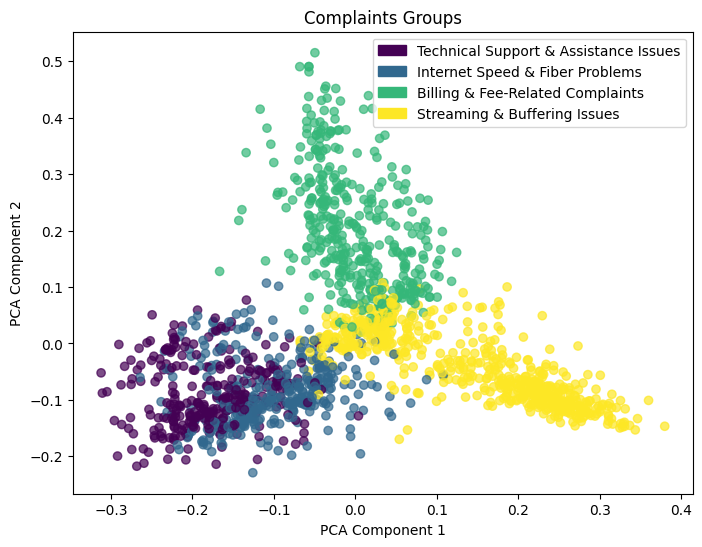

In [45]:
X_dense = X_tfidf.toarray()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0],
                      X_pca[:, 1],
                      c=df_complaints['cluster_label'],
                      cmap='viridis',
                      alpha=0.7)
#plt.colorbar(scatter, label='Cluster')
plt.title("Complaints Groups")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
patches = []
for cluster_id in sorted(cluster_labels.keys()):
    color = scatter.cmap(scatter.norm(cluster_id))
    patch = mpatches.Patch(color=color, label=cluster_labels[cluster_id])
    patches.append(patch)

plt.legend(handles=patches)
plt.show()


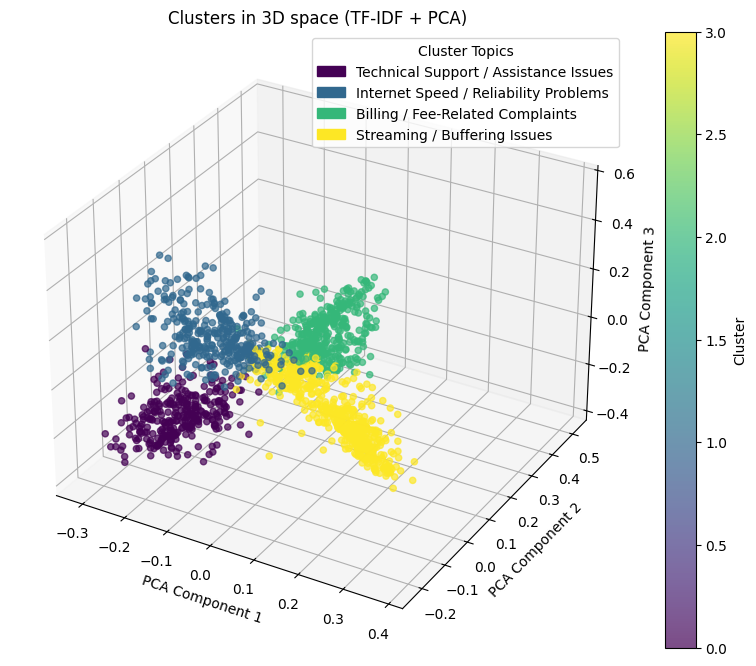

In [13]:
from mpl_toolkits.mplot3d import Axes3D

X_dense = X_tfidf.toarray()

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_dense)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=df_complaints['cluster_label'],
    cmap='viridis',
    alpha=0.7
)

ax.set_title("Clusters in 3D space (TF-IDF + PCA)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
patches = []
for cluster_id in sorted(cluster_labels.keys()):
    color = scatter.cmap(scatter.norm(cluster_id))
    patch = mpatches.Patch(color=color, label=cluster_labels[cluster_id])
    patches.append(patch)

plt.legend(handles=patches, title="Cluster Topics")
plt.colorbar(scatter, label='Cluster')
plt.show()

In [46]:
df_clients = pd.read_excel("/content/drive/MyDrive/Hackaton/Code/clients.xlsx")

In [48]:
df_merge_complaints = df_complaints.merge(df_clients, on='customerID', how='left')

In [51]:
df_merge_complaints.head(5)

,customerID,complaint,complaint_number,clean_complaint,cluster_label,cluster_topic,gender,SeniorCitizen,Partner,Dependents,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,9565-DJPIB,The streaming TV service frequently buffers or...,1,streaming tv service frequently buffer crash m...,0,Technical Support & Assistance Issues,Female,0,No,Yes,...,No,No,Yes,No,Month-to-month,No,Mailed check,89.6,365.65,Yes
1,4342-HFXWS,The DSL internet service has been inconsistent...,1,dsl internet service inconsistent lately frequ...,1,Internet Speed & Fiber Problems,Female,0,Yes,Yes,...,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),69.7,3023.65,No
2,4342-HFXWS,The streaming TV service often buffers excessi...,2,streaming tv service often buffer excessively ...,0,Technical Support & Assistance Issues,Female,0,Yes,Yes,...,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),69.7,3023.65,No
3,4342-HFXWS,"Despite having tech support included, it takes...",3,despite tech support included take long time g...,3,Streaming & Buffering Issues,Female,0,Yes,Yes,...,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),69.7,3023.65,No
4,4342-HFXWS,The device protection plan I pay for did not c...,4,device protection plan pay cover recent issue ...,3,Streaming & Buffering Issues,Female,0,Yes,Yes,...,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),69.7,3023.65,No


In [53]:
# ------------------------------------------------------------
# 0)  Numeric churn flag  (0 = no churn, 1 = churn)
# ------------------------------------------------------------
df_merge_complaints["churn_flag"] = (
    df_merge_complaints["Churn"]
        .str.strip()            # safety: remove stray spaces
        .map({"No": 0, "Yes": 1})
)

# ------------------------------------------------------------
# 1)  Churn stats + relative frequency by cluster
# ------------------------------------------------------------
total_customers = len(df_merge_complaints)

churn_by_cluster = (df_merge_complaints
    .groupby(["cluster_label", "cluster_topic"], as_index=False)
    .agg(customers     = ("churn_flag", "size"),
         churners      = ("churn_flag", "sum"))
    .assign(churn_rate = lambda d: d["churners"]  / d["customers"],
            cluster_share = lambda d: d["customers"] / total_customers)  # NEW
    .sort_values("cluster_label")
)

print("\nChurn rate by cluster")
print(churn_by_cluster.to_string(
        index=False,
        formatters={
            "churn_rate"   : "{:.2%}".format,
            "cluster_share": "{:.2%}".format      # pretty‑print share
        }))

# ------------------------------------------------------------
# 2)  Overall churn rate
# ------------------------------------------------------------
overall_churn_rate = df_merge_complaints["churn_flag"].mean()
print("\nOverall churn rate: {:.2%}".format(overall_churn_rate))

# ------------------------------------------------------------
# 3)  Chi‑square test
# ------------------------------------------------------------
cross_tab = pd.crosstab(df_merge_complaints["cluster_label"],
                        df_merge_complaints["churn_flag"])

chi2, p, dof, expected = stats.chi2_contingency(cross_tab)

print("\nChi‑square test")
print(f"χ² = {chi2:.2f},  dof = {dof},  p‑value = {p:.4f}")




Churn rate by cluster
 cluster_label                         cluster_topic  customers  churners churn_rate cluster_share
             0 Technical Support & Assistance Issues        297       179     60.27%        18.50%
             1       Internet Speed & Fiber Problems        325       233     71.69%        20.25%
             2      Billing & Fee-Related Complaints        385       212     55.06%        23.99%
             3          Streaming & Buffering Issues        598       367     61.37%        37.26%

Overall churn rate: 61.74%

Chi‑square test
χ² = 21.20,  dof = 3,  p‑value = 0.0001


# Cluster by CLIENT

In [15]:
df_aggregated = df_complaints.groupby('customerID', as_index=False).agg({
    'clean_complaint': lambda texts: " ".join(texts),
    'complaint': lambda texts: " ".join(texts)
})
print("Aggregated dataframe shape:", df_aggregated.shape)
print(df_aggregated.head())

Aggregated dataframe shape: (704, 3)
   customerID                                    clean_complaint  \
0  0003-MKNFE  streaming movie service often buffer freeze ma...   
1  0011-IGKFF  internet service unreliable frequent downtime ...   
2  0014-BMAQU  internet speed inconsistent lately frustrating...   
3  0020-JDNXP  streaming service signed frequently buffer fai...   
4  0022-TCJCI  internet speed consistently slower promised pl...   

                                           complaint  
0  The streaming movies service often buffers and...  
1  The internet service has been unreliable, with...  
2  The internet speed has been inconsistent latel...  
3  The streaming services I signed up for frequen...  
4  The internet speed has been consistently slowe...  


In [16]:
tfidf = TfidfVectorizer(
    min_df=2,
    max_df=0.9,
    ngram_range=(1, 3),
    stop_words='english',
    sublinear_tf=True,
    max_features=2000
)
X_tfidf_agg = tfidf.fit_transform(df_aggregated['clean_complaint'])
print("TF-IDF matrix shape (aggregated):", X_tfidf_agg.shape)

TF-IDF matrix shape (aggregated): (704, 2000)


In [17]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels_agg = kmeans.fit_predict(X_tfidf_agg)
df_aggregated['cluster_label'] = labels_agg

In [18]:
feature_names = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

cluster_top_terms = {}
for cluster in range(num_clusters):
    top_terms = [feature_names[ind] for ind in order_centroids[cluster, :20]]
    cluster_top_terms[cluster] = top_terms
    print(f"Cluster {cluster} Top Terms: {', '.join(top_terms)}")

Cluster 0 Top Terms: streaming, buffer, movie, tv, frequently, frequently buffer, streaming service, issue, paying, support, impossible, im, despite, enjoy, frustrating, buffering, tv movie, monthly, streaming tv, high
Cluster 1 Top Terms: internet, speed, slow, support, internet service, online, issue, extremely, unreliable, despite, frequent, internet speed, difficult, outage, service extremely, frequent outage, tech, tech support, internet service extremely, paying
Cluster 2 Top Terms: phone, phone service, loyal, loyal customer, year, option, customer, loyal customer year, customer year, like, internet service, internet, available, feel, frustrated, service option, despite, ive, poor, lack


In [20]:
cluster_labels = {
    0: "Streaming & Buffering Issues",
    1: "Slow & Unreliable Internet",
    2: "Phone Service Issues"
}

df_aggregated['cluster_topic'] = df_aggregated['cluster_label'].map(cluster_labels)
print(df_aggregated[['customerID', 'cluster_label', 'cluster_topic']].head())


   customerID  cluster_label                 cluster_topic
0  0003-MKNFE              0  Streaming & Buffering Issues
1  0011-IGKFF              1    Slow & Unreliable Internet
2  0014-BMAQU              1    Slow & Unreliable Internet
3  0020-JDNXP              0  Streaming & Buffering Issues
4  0022-TCJCI              1    Slow & Unreliable Internet


In [21]:
output_path = '/content/drive/MyDrive/Hackaton/df_aggregated.csv'
df_aggregated.to_csv(output_path, index=False)
print(f"df_aggregated has been saved to {output_path}")

df_aggregated has been saved to /content/drive/MyDrive/Hackaton/df_aggregated.csv


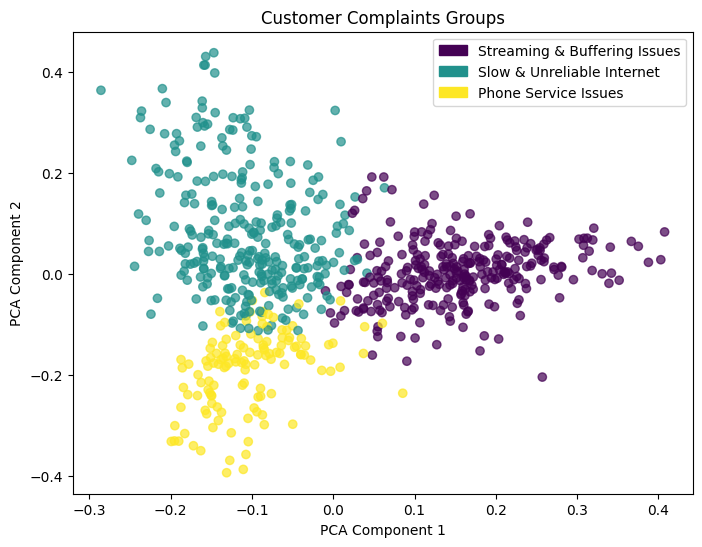

In [26]:
X_dense_agg = X_tfidf_agg.toarray()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense_agg)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0],
                      X_pca[:, 1],
                      c=df_aggregated['cluster_label'],
                      cmap='viridis',
                      alpha=0.7)
plt.title("Customer Complaints Groups")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

patches = []
for cluster_id in sorted(cluster_labels.keys()):
    color = scatter.cmap(scatter.norm(cluster_id))
    patch = mpatches.Patch(color=color, label=cluster_labels[cluster_id])
    patches.append(patch)

plt.legend(handles=patches)
plt.show()


## Clients by churn

In [27]:
df_clients = pd.read_excel("/content/drive/MyDrive/Hackaton/Code/clients.xlsx")
df_clients.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [28]:
df_stats = df_aggregated.copy()
df_stats.set_index('customerID', inplace=True)
df_clients.set_index('customerID', inplace=True)

df_merged = df_stats.join(df_clients[['Churn']], how='inner')
print("Merged shape:", df_merged.shape)
print(df_merged.head())

Merged shape: (704, 5)
                                              clean_complaint  \
customerID                                                      
0003-MKNFE  streaming movie service often buffer freeze ma...   
0011-IGKFF  internet service unreliable frequent downtime ...   
0014-BMAQU  internet speed inconsistent lately frustrating...   
0020-JDNXP  streaming service signed frequently buffer fai...   
0022-TCJCI  internet speed consistently slower promised pl...   

                                                    complaint  cluster_label  \
customerID                                                                     
0003-MKNFE  The streaming movies service often buffers and...              0   
0011-IGKFF  The internet service has been unreliable, with...              1   
0014-BMAQU  The internet speed has been inconsistent latel...              1   
0020-JDNXP  The streaming services I signed up for frequen...              0   
0022-TCJCI  The internet speed has been c

In [29]:
df_merged['Churn'] = df_merged['Churn'].map({'No': 0, 'Yes': 1})

In [30]:
import scipy.stats as stats

cluster_stats = df_merged.groupby('cluster_label')['Churn'].agg(['count', 'sum'])
cluster_stats['churn_rate'] = cluster_stats['sum'] / cluster_stats['count']
print("Churn Statistics by Cluster:")
print(cluster_stats)

overall_churn_rate = df_merged['Churn'].mean()
print("\nOverall Churn Rate: {:.2%}".format(overall_churn_rate))

cross_tab = pd.crosstab(df_merged['cluster_label'], df_merged['Churn'])
print("\nCross Tabulation (Counts):")
print(cross_tab)

chi2, p, dof, expected = stats.chi2_contingency(cross_tab)
print("\nChi-Square Test:")
print("Chi-square statistic: {:.2f}".format(chi2))
print("Degrees of Freedom:", dof)
print("p-value: {:.4f}".format(p))
print("Expected Frequencies:")
print(expected)

Churn Statistics by Cluster:
               count  sum  churn_rate
cluster_label                        
0                285  172    0.603509
1                291  216    0.742268
2                128   37    0.289062

Overall Churn Rate: 60.37%

Cross Tabulation (Counts):
Churn            0    1
cluster_label          
0              113  172
1               75  216
2               91   37

Chi-Square Test:
Chi-square statistic: 76.32
Degrees of Freedom: 2
p-value: 0.0000
Expected Frequencies:
[[112.94744318 172.05255682]
 [115.32528409 175.67471591]
 [ 50.72727273  77.27272727]]


In [ ]:
X_dense_agg = X_tfidf_agg.toarray()

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense_agg)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0],
                      X_pca[:, 1],
                      c=df_aggregated['cluster_label'],
                      cmap='viridis',
                      alpha=0.7)
plt.title("Customer Complaints Groups")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

patches = []
for cluster_id in sorted(cluster_labels.keys()):
    color = scatter.cmap(scatter.norm(cluster_id))
    patch = mpatches.Patch(color=color, label=cluster_labels[cluster_id])
    patches.append(patch)

plt.legend(handles=patches)
plt.show()

# Sentiment Analysis


In [ ]:
from textblob import TextBlob

In [ ]:
import re

NEGATION_WORDS = {"not", "no", "never", "none", "nobody", "nothing", "nor"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r"[^a-zA-Z0-9!\?'\s]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_aggregated['sent_comp'] = df_aggregated['complaint'].apply(clean_text)

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
def get_sentiment_bert(text):
    result = sentiment_pipeline(text[:512])[0]
    label = result['label']
    score = result['score']

    if label == 'NEGATIVE':
        return -score
    else:
        return score

df_aggregated['sentiment'] = df_aggregated['sent_comp'].apply(get_sentiment_bert)


In [ ]:
cluster_sentiment_stats = df_aggregated.groupby(['cluster_label','cluster_topic'])['sentiment'].agg(['mean', 'median', 'count'])
print(cluster_sentiment_stats)

                                                    mean    median  count
cluster_label cluster_topic                                              
0             TV / Streaming Issues            -0.998443 -0.999608    285
1             Internet Service Complaints      -0.992350 -0.999641    291
2             Phone Service / Customer Loyalty -0.996398 -0.999540    128


In [ ]:
emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_pipeline = pipeline("text-classification", model=emotion_model_name, top_k=None)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
def get_emotions(text):
    """Returns (top_emotion, emotions_dict) from a list-of-lists structure."""
    result = emotion_pipeline(text[:512])

    if not result:
        return None, {}

    emotion_list = result[0]

    if not emotion_list:
        return None, {}

    emotions_dict = {d['label']: d['score'] for d in emotion_list}
    top_emotion_dict = max(emotion_list, key=lambda x: x['score'])
    top_emotion = top_emotion_dict['label']

    return top_emotion, emotions_dict



In [ ]:
test_output = emotion_pipeline("I am extremely frustrated and angry with this service!")
print(test_output)


[[{'label': 'anger', 'score': 0.9844925403594971}, {'label': 'disgust', 'score': 0.0027536877896636724}, {'label': 'fear', 'score': 0.0022210299503058195}, {'label': 'joy', 'score': 0.0006833519437350333}, {'label': 'neutral', 'score': 0.0035417776089161634}, {'label': 'sadness', 'score': 0.003310522995889187}, {'label': 'surprise', 'score': 0.002997009549289942}]]


In [ ]:
df_aggregated[['top_emotion','emotions_dict']] = df_aggregated['sent_comp'].apply(
    lambda txt: pd.Series(get_emotions(txt))
)


In [ ]:
test_txt = df_aggregated['sent_comp'].iloc[0]
test_output = emotion_pipeline(test_txt[:512])
print("Raw pipeline output:\n", test_output)


Raw pipeline output:
 [[{'label': 'anger', 'score': 0.12418124079704285}, {'label': 'disgust', 'score': 0.0009700406808406115}, {'label': 'fear', 'score': 0.004574018530547619}, {'label': 'joy', 'score': 0.0166097991168499}, {'label': 'neutral', 'score': 0.01805763691663742}, {'label': 'sadness', 'score': 0.7999937534332275}, {'label': 'surprise', 'score': 0.03561355918645859}]]


In [ ]:
print("Columns:", df_aggregated.columns.tolist())
print(df_aggregated[['cluster_label', 'cluster_topic', 'top_emotion']].head(10))


Columns: ['customerID', 'clean_complaint', 'complaint', 'cluster_label', 'cluster_topic', 'sentiment', 'sent_comp', 'top_emotion', 'emotions_dict', 'score_anger', 'score_disgust', 'score_fear', 'score_joy', 'score_neutral', 'score_sadness', 'score_surprise']
   cluster_label                     cluster_topic top_emotion
0              0             TV / Streaming Issues     sadness
1              1       Internet Service Complaints     sadness
2              1       Internet Service Complaints     sadness
3              0             TV / Streaming Issues     sadness
4              1       Internet Service Complaints     sadness
5              1       Internet Service Complaints     sadness
6              1       Internet Service Complaints     sadness
7              2  Phone Service / Customer Loyalty       anger
8              1       Internet Service Complaints     sadness
9              1       Internet Service Complaints       anger


In [ ]:
emotion_counts = df_aggregated.groupby(
    ['cluster_label','cluster_topic','top_emotion']
).size().reset_index(name='count')
print(emotion_counts.head(20))

    cluster_label                     cluster_topic top_emotion  count
0               0             TV / Streaming Issues       anger     60
1               0             TV / Streaming Issues        fear      8
2               0             TV / Streaming Issues         joy      4
3               0             TV / Streaming Issues     neutral      1
4               0             TV / Streaming Issues     sadness    208
5               0             TV / Streaming Issues    surprise      4
6               1       Internet Service Complaints       anger     64
7               1       Internet Service Complaints        fear     14
8               1       Internet Service Complaints         joy      6
9               1       Internet Service Complaints     neutral      4
10              1       Internet Service Complaints     sadness    202
11              1       Internet Service Complaints    surprise      1
12              2  Phone Service / Customer Loyalty       anger     49
13    

In [ ]:
emotion_pivot = emotion_counts.pivot_table(
    index=['cluster_label','cluster_topic'],
    columns='top_emotion',
    values='count',
    fill_value=0
)
print(emotion_pivot)


top_emotion                                     anger  fear   joy  neutral  \
cluster_label cluster_topic                                                  
0             TV / Streaming Issues              60.0   8.0   4.0      1.0   
1             Internet Service Complaints        64.0  14.0   6.0      4.0   
2             Phone Service / Customer Loyalty   49.0   2.0  13.0      0.0   

top_emotion                                     sadness  surprise  
cluster_label cluster_topic                                        
0             TV / Streaming Issues               208.0       4.0  
1             Internet Service Complaints         202.0       1.0  
2             Phone Service / Customer Loyalty     63.0       1.0  


In [ ]:
def extract_emotion_scores(emotions_dict, emotion_list):
    return [emotions_dict.get(e, 0.0) for e in emotion_list]

model_emotions = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]

for e in model_emotions:
    df_aggregated[f"score_{e}"] = df_aggregated['emotions_dict'].apply(lambda d: d.get(e, 0.0))

emotions_score_stats = df_aggregated.groupby(['cluster_label','cluster_topic'])[
    [f"score_{e}" for e in model_emotions]
].mean()

print(emotions_score_stats)


                                                score_anger  score_disgust  \
cluster_label cluster_topic                                                  
0             TV / Streaming Issues                0.281531       0.003644   
1             Internet Service Complaints          0.301001       0.002839   
2             Phone Service / Customer Loyalty     0.427271       0.001395   

                                                score_fear  score_joy  \
cluster_label cluster_topic                                             
0             TV / Streaming Issues               0.034493   0.017181   
1             Internet Service Complaints         0.051334   0.025770   
2             Phone Service / Customer Loyalty    0.019886   0.115613   

                                                score_neutral  score_sadness  \
cluster_label cluster_topic                                                    
0             TV / Streaming Issues                  0.030212       0.588754   
1  

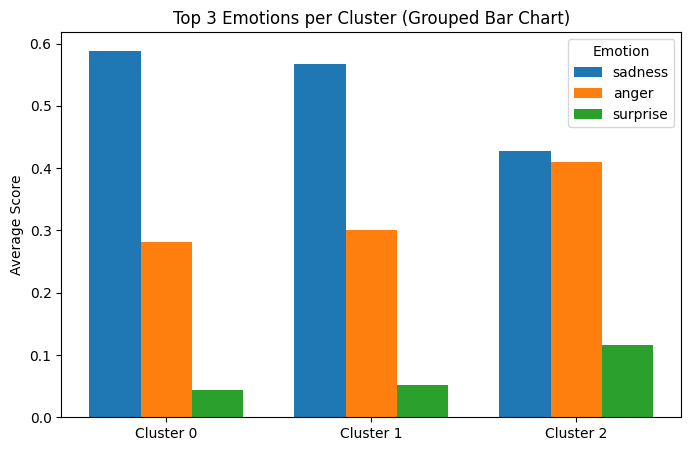

In [ ]:
top_3_dict = {}
for idx, row in emotions_score_stats.iterrows():
    if isinstance(idx, tuple):
        cluster_label = idx[0]
    else:
        cluster_label = idx

    top_3 = row.nlargest(3)
    items = list(top_3.items())
    top_3_dict[cluster_label] = items

unique_clusters = sorted(top_3_dict.keys())
x = np.arange(len(unique_clusters))
width = 0.25
offsets = [-width, 0, width]
colors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6"]

fig, ax = plt.subplots(figsize=(8, 5))

for i, cluster in enumerate(unique_clusters):
    top_3_items = top_3_dict[cluster]
    for j, (emotion_col, score_val) in enumerate(top_3_items):
        emotion_name = emotion_col.replace("score_", "")
        bar_x = x[i] + offsets[j]

        ax.bar(bar_x, score_val, width=width,
               color=colors[j % len(colors)],
               label=emotion_name if i == 0 else None)

ax.set_xticks(x)
ax.set_xticklabels([f"Cluster {c}" for c in unique_clusters])
ax.set_ylabel("Average Score")
ax.set_title("Top 3 Emotions per Cluster (Grouped Bar Chart)")

ax.legend(title="Emotion")

plt.show()
